# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [19]:
# Install imageio for imread as imread from scipy.misc is deprecated

# !pip install imageio
# !pip install opencv-python

In [20]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [21]:
import numpy as np
import os

# following in deprecated:
# from scipy.misc import imread, imresize
from imageio import imread
from PIL import Image
import cv2

import datetime
import os

In [22]:
os.chdir('/content/gdrive/My Drive/Colab Notebooks')
!mkdir Project_data2
!unzip -q Project_data.zip -d Project_data2/

We set the random seed so that the results don't vary drastically.

In [23]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf

# set_random_seed is deprecated.
# tf.set_random_seed(30)
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [24]:
# train_doc = np.random.permutation(open('/notebooks/storage/Final_data/Collated_training/train.csv').readlines())
# val_doc = np.random.permutation(open('/notebooks/storage/Final_data/Collated_training/val.csv').readlines())

train_doc = np.random.permutation(open('Project_data2/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('Project_data2/Project_data/val.csv').readlines())

batch_size = 64 #experiment with the batch size

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [25]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = np.round(np.linspace(0, 29, 30)).astype(int) #list of image numbers for video.
    while True:
        t = np.random.permutation(folder_list)
        if len(t) % batch_size == 0: # if divisible by batch_size
            num_batches = int(len(t)/batch_size)
        else:  #if not divisible by batch_size
            num_batches = len(t) // batch_size
            last_batch_size = len(t) % batch_size #surplus in the last batch
        
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,len(img_idx),100,100,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    resized_image = cv2.resize(image,(100,100))
                    
                    batch_data[folder,idx,:,:,0] = (resized_image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (resized_image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (resized_image[:,:,2])/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        batch_data = np.zeros((batch_size,len(img_idx),100,100,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
        batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
        for folder in range(last_batch_size): # iterate over the batch_size
            imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
            for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                resized_image = cv2.resize(image,(100,100))

                batch_data[folder,idx,:,:,0] = (resized_image[:,:,0])/255
                batch_data[folder,idx,:,:,1] = (resized_image[:,:,1])/255
                batch_data[folder,idx,:,:,2] = (resized_image[:,:,2])/255

            batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
        yield batch_data, batch_labels


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [26]:
curr_dt_time = datetime.datetime.now()
# train_path = '/notebooks/storage/Final_data/Collated_training/train'
# val_path = '/notebooks/storage/Final_data/Collated_training/val'
train_path = 'Project_data2/Project_data/train'
val_path = 'Project_data2/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20# choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [27]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

In [28]:
# Conv3D model
model = Sequential()
model.add(Conv3D(16, (3,3,3), # filters, kernel size
                 padding = 'same', 
                 input_shape = (30,100,100,3))) #frames per sample, height, weight, channels
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2,2,2)))

model.add(Conv3D(32, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Conv3D(64, (2, 2, 2), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2, 2)))

model.add(Flatten())
model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(64,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(5,activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [29]:
optimiser = 'adam'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, 30, 100, 100, 16)  1312      
_________________________________________________________________
activation (Activation)      (None, 30, 100, 100, 16)  0         
_________________________________________________________________
batch_normalization (BatchNo (None, 30, 100, 100, 16)  64        
_________________________________________________________________
max_pooling3d (MaxPooling3D) (None, 15, 50, 50, 16)    0         
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 15, 50, 50, 32)    4128      
_________________________________________________________________
activation_1 (Activation)    (None, 15, 50, 50, 32)    0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 15, 50, 50, 32)    1

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [30]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [31]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', period=1)

#reduce learning rate when val_loss has stopped improving.
#monitor -> metric to monitor
#verbose -> prints message to stdout
#patience -> number of epochs with no imporvement after which learning rate is reduced
#factor -> factor by which learning rate is reduced.
LR = ReduceLROnPlateau(monitor='val_loss', factor= 0.2, verbose=1,patience=5)
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [32]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [33]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  Project_data2/Project_data/train ; batch size = 64


/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
11/11 [==============================] - 178s 14s/step - loss: 1.6389 - categorical_accuracy: 0.3622 - val_loss: 1.2367 - val_categorical_accuracy: 0.1797

Epoch 00001: saving model to model_init_2021-10-1910_50_01.541796/model-00001-1.63889-0.36222-1.23673-0.17969.h5
Epoch 2/20
11/11 [==============================] - 152s 15s/step - loss: 1.0364 - categorical_accuracy: 0.5327 - val_loss: 1.5402 - val_categorical_accuracy: 0.1641

Epoch 00002: saving model to model_init_2021-10-1910_50_01.541796/model-00002-1.03638-0.53267-1.54015-0.16406.h5
Epoch 3/20
11/11 [==============================] - 148s 15s/step - loss: 0.8400 - categorical_accuracy: 0.6420 - val_loss: 2.1351 - val_categorical_accuracy: 0.1797

Epoch 00003: saving model to model_init_2021-10-1910_50_01.541796/model-00003-0.83998-0.64205-2.13509-0.17969.h5
Epoch 4/20
11/11 [==============================] - 115s 11s/step - loss: 0.6661 - categorical_accuracy: 0.7116 - val_loss: 2.1230 - val_categorical_accuracy: 0

In [34]:
history = model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                              callbacks=callbacks_list, validation_data=val_generator, 
                              validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
11/11 [==============================] - 122s 12s/step - loss: 0.2755 - categorical_accuracy: 0.8693 - val_loss: 2.5638 - val_categorical_accuracy: 0.1719

Epoch 00001: saving model to model_init_2021-10-1910_50_01.541796/model-00001-0.27553-0.86932-2.56375-0.17188.h5
Epoch 2/20
11/11 [==============================] - 131s 13s/step - loss: 0.2404 - categorical_accuracy: 0.8906 - val_loss: 2.3928 - val_categorical_accuracy: 0.1719

Epoch 00002: saving model to model_init_2021-10-1910_50_01.541796/model-00002-0.24044-0.89062-2.39284-0.17188.h5
Epoch 3/20
11/11 [==============================] - 132s 13s/step - loss: 0.2698 - categorical_accuracy: 0.8722 - val_loss: 2.5096 - val_categorical_accuracy: 0.1875

Epoch 00003: saving model to model_init_2021-10-1910_50_01.541796/model-00003-0.26983-0.87216-2.50957-0.18750.h5
Epoch 4/20
11/11 [==============================] - 121s 12s/step - loss: 0.2594 - categorical_accuracy: 0.8707 - val_loss: 2.4447 - val_categorical_accuracy: 0

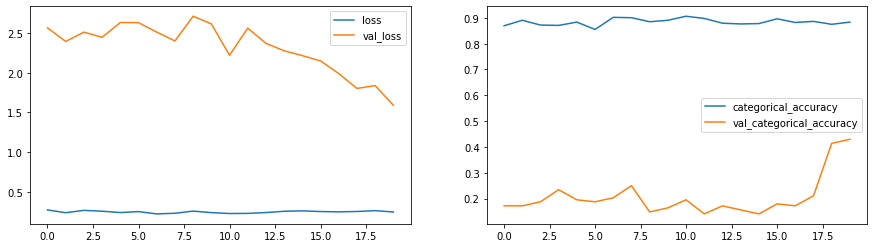

In [37]:
import matplotlib.pyplot as plt
% matplotlib inline
def train_val_loss_plot(history):
      fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
      axes[0].plot(history.history['loss'])   
      axes[0].plot(history.history['val_loss'])
      axes[0].legend(['loss','val_loss'])

      axes[1].plot(history.history['categorical_accuracy'])   
      axes[1].plot(history.history['val_categorical_accuracy'])
      axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

train_val_loss_plot(history)